# Time serie forecasting

This notebook is an attempt to use LSTM for time series forecasting. I start with the Lorentz attractor as a toy example, as in Hsu, Daniel. "Time Series Forecasting Based on Augmented Long Short-Term Memory." arXiv preprint arXiv:1707.00666 (2017).

In [2]:
import numpy as np
from scipy.integrate import ode

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

In [3]:
def Lorenz_func(t,y, sigma = 10., rho = 28., beta = 8./3.):
    f = np.zeros_like(y)
    f[0] = sigma*(y[1]-y[0])
    f[1] = rho*y[0]-y[1]-y[0]*y[2]
    f[2] = y[0]*y[1] - beta*y[2]
    return f

In [119]:
y0 = np.random.standard_normal((3,))
t0,t1 = 0.,10000.
t = np.linspace(t0,t1,int(1e6))
dt = t[1]-t[0]
r = ode(Lorenz_func)
r.set_initial_value(y0, t0);

In [5]:
i=0
y = np.zeros([t.size,3])
y[0,:] = y0
while r.successful() and i < t.size-1:
    r.integrate(r.t+dt)
    y[i+1,:] = r.y
    i+=1

In [7]:
def normalize(x):
    return (x-x.mean())/x.std()

In [8]:
y[:,0] =normalize(y[:,0])
y[:,1] =normalize(y[:,1])
y[:,2] =normalize(y[:,2])

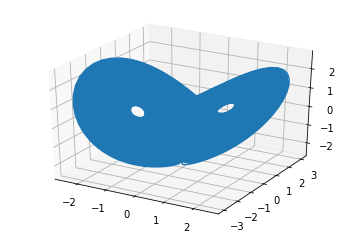

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(y[:,0],y[:,1],zs = y[:,2])

# Convolutional forecasting model

In [51]:
import tensorflow as tf
import numpy as np
from random import shuffle

import keras

from keras import regularizers

from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Input, Reshape, Lambda
from keras.layers import LSTM

from keras.models import Model, Sequential

from keras.optimizers import Adam

In [52]:
input_length = 100
input_dim = 3
output_length = 50
output_dim = 3
def generate_batch(x, N_batch = 5000):
    init = np.random.randint(len(x)-input_length-output_length, size = N_batch)
    train_data = np.zeros([N_batch, input_length, input_dim])
    y_true = np.zeros([N_batch, output_length, output_dim])
    for i in range(N_batch):
        z = x[init[i]:init[i]+input_length+output_length,:]
        train_data[i,:] = z[:input_length,:]
        y_true[i,:] = z[input_length:,:]
#         y_true[i,:] = np.diff(z[input_length-1:,:])
    return (train_data, y_true)

In [112]:
inputs = Input(shape=(input_length,input_dim))

num_filters = 32
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           activation = 'relu')(inputs)
num_filters = 32
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)

lstm_output_dim = 8
units = output_length*lstm_output_dim
x = LSTM(units, activation = 'tanh', return_sequences = False)(x)

x = Reshape((output_length, lstm_output_dim))(x)
num_filters = 8
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = 64
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = output_dim
kernel_size = 1
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = None)(x)

predictor = Model(inputs = inputs, outputs = x)
predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 98, 32)            320       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 48, 32)            3104      
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               692800    
_________________________________________________________________
reshape_10 (Reshape)         (None, 50, 8)             0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 50, 8)             200       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 50, 64)            1600      
__________

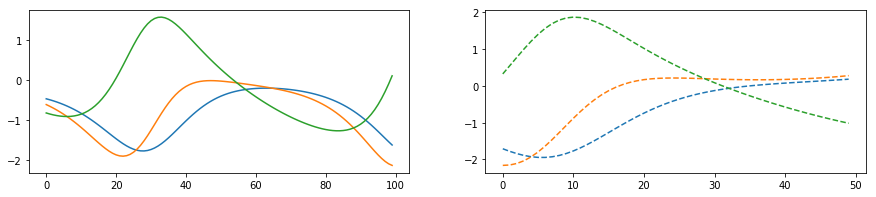

In [113]:
# set aside some data for testing
test = y[-int(1e4):]
# generate a batch
batch = generate_batch(y[:-int(1e4)])
# plot an example of sequence data and expected predictions
x_train, y_true = batch
f, ax = plt.subplots(1, 2, squeeze=False, figsize = (15,3))
ax[0,0].plot(x_train[0,:,:].squeeze());
ax[0,1].plot(y_true[0,:,:].squeeze(),'--');

I have a hard time deciding between training via mean absolute error (a fairly usual error metric in time serie forecasting apparently) and mean squared error, which is a more usual error function across domains. So I alternate between the two.

Usually I'd keep the same learning rate between two training bouts, but the mean absolute error has the peculiar feature that it's profile is sharp: the gradient doesn't naturally decrease when you get closer to perfect fit, meaning it requires a lower learning rate at a given stage than the mean squared error. On the other hand by the time I start training with MSE we're closer to the minimum, at which point we'd usually reduce the learning rate. I assume these two effects cancel out. The schedule below is basically an interation of this (I haven't optimized it much):

In [105]:
def train(predictor, learning_rate, batch, 
          beta=0.9, epochs = 10, initial = 0, 
          callbacks = [keras.callbacks.ReduceLROnPlateau(verbose=1, patience = 1, factor = .1),] ):
    
    x_train, y_true = batch
    
    lr = learning_rate
    beta = 0.9
    loss = 'mean_absolute_error'
    optimizer = Adam(lr,beta)
    predictor.compile(loss = loss, optimizer = optimizer)
    
    initial_epoch = initial
    num_epochs = initial_epoch + epochs
    hist0 = predictor.fit(x_train, y_true, epochs = num_epochs, initial_epoch = initial_epoch, callbacks = callbacks, validation_split = .1)

    lr = learning_rate
    beta = 0.9
    loss = 'mean_squared_error'
    optimizer = Adam(lr,beta)
    predictor.compile(loss = loss, optimizer = optimizer)

    initial_epoch = num_epochs
    num_epochs = initial_epoch + epochs
    hist1 = predictor.fit(x_train, y_true, epochs = num_epochs, initial_epoch = initial_epoch, callbacks = callbacks, validation_split = .1)
    return hist0, hist1

In [114]:
hist0 = train(predictor, 1e-2, batch, epochs = 30)
hist1 = train(predictor, 1e-4, batch, epochs = 10)
hist2 = train(predictor, 1e-5, batch, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 9s - loss: 0.3468 - val_loss: 0.1918
Epoch 2/30
4500/4500 [==============================] - 7s - loss: 0.1676 - val_loss: 0.1495
Epoch 3/30
4500/4500 [==============================] - 7s - loss: 0.1367 - val_loss: 0.1520
Epoch 4/30
4500/4500 [==============================] - 7s - loss: 0.1268 - val_loss: 0.1337
Epoch 5/30
4500/4500 [==============================] - 7s - loss: 0.1137 - val_loss: 0.1109
Epoch 6/30
4500/4500 [==============================] - 7s - loss: 0.1036 - val_loss: 0.1026ss: 0.1
Epoch 7/30
4500/4500 [==============================] - 7s - loss: 0.0995 - val_loss: 0.0867
Epoch 8/30
4500/4500 [==============================] - 7s - loss: 0.0987 - val_loss: 0.1042
Epoch 9/30
4480/4500 [============================>.] - ETA: 0s - loss: 0.0981
Epoch 00008: reducing learning rate to 0.0009999999776482583.
4500/4500 [==============================] - 8s - loss: 0.098

4500/4500 [==============================] - 9s - loss: 0.0017 - val_loss: 0.0018
Epoch 12/20
4500/4500 [==============================] - 7s - loss: 0.0017 - val_loss: 0.0018
Epoch 13/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00012: reducing learning rate to 9.999999747378752e-06.
4500/4500 [==============================] - 9s - loss: 0.0016 - val_loss: 0.0018
Epoch 14/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00013: reducing learning rate to 9.999999747378752e-07.
4500/4500 [==============================] - 7s - loss: 0.0016 - val_loss: 0.0018
Epoch 15/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00014: reducing learning rate to 9.999999974752428e-08.
4500/4500 [==============================] - 7s - loss: 0.0016 - val_loss: 0.0018
Epoch 16/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00015: reducing learning rate to 1.0000000116860975e-08.
4500/4500

The end MSE error is 0.0017, which gives a RMSE of 0.04 - slightly worse worse than the paper (which reached around 0.02), but the model is, as far as I know, very different from the original paper aside from the presence of a LSTM cell (for example, the training sequence is 100 instead of 1000).

In [115]:
i=np.random.randint(test.shape[0]-(input_length+output_length))
x_test = test[i:i+input_length+output_length,:]
# y_test = np.diff(x_test[-(output_length+1):,:],axis=0)
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = predictor.predict(np.expand_dims(x_test, axis=0)).squeeze()

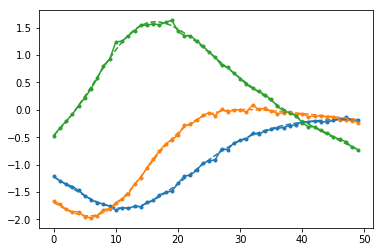

In [116]:
plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'--');

In [66]:
# let's give the model something with a more innocuous name to avoid overwriting it
pred_0 = keras.models.clone_model(predictor)
pred_0.set_weights(predictor.get_weights())

Let's try a different architecture with a sharper reduction in the temporal dimension:

In [106]:
inputs = Input(shape=(input_length,input_dim))

# feature selection
num_filters = 32
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           activation = 'relu')(inputs)
num_filters = 64
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)
num_filters = 128
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)
num_filters = 256
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)

# lstm unit
lstm_output_dim = 8
units = output_length*lstm_output_dim
x = LSTM(units, activation = 'tanh', return_sequences = False)(x)

# interpreting the output
x = Reshape((output_length, lstm_output_dim))(x)
num_filters = 8
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = 64
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = output_dim
kernel_size = 1
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = None)(x)

predictor = Model(inputs = inputs, outputs = x)
predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 98, 32)            320       
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 48, 64)            6208      
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 23, 128)           24704     
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 11, 256)           98560     
_________________________________________________________________
lstm_8 (LSTM)                (None, 400)               1051200   
_________________________________________________________________
reshape_9 (Reshape)          (None, 50, 8)             0         
__________

The model has twice as many parameters, but the LSTM only unrolls on a sequence of length 11 instead of 49, so it should be faster to train.

In [ ]:
# set aside some data for testing
test = y[-int(1e4):]
# generate a batch
batch = generate_batch(y[:-int(1e4)])

In [107]:
hist0 = train(predictor, 1e-2, batch, epochs = 30)
hist1 = train(predictor, 1e-4, batch, epochs = 10)
hist2 = train(predictor, 1e-5, batch, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 4s - loss: 0.4160 - val_loss: 0.2476
Epoch 2/30
4500/4500 [==============================] - 2s - loss: 0.2172 - val_loss: 0.2125
Epoch 3/30
4500/4500 [==============================] - 2s - loss: 0.1955 - val_loss: 0.1808
Epoch 4/30
4500/4500 [==============================] - 2s - loss: 0.1690 - val_loss: 0.1535
Epoch 5/30
4500/4500 [==============================] - 2s - loss: 0.1638 - val_loss: 0.2035
Epoch 6/30
4448/4500 [============================>.] - ETA: 0s - loss: 0.1562
Epoch 00005: reducing learning rate to 0.0009999999776482583.
4500/4500 [==============================] - 3s - loss: 0.1561 - val_loss: 0.1545
Epoch 7/30
4500/4500 [==============================] - 2s - loss: 0.1171 - val_loss: 0.1098
Epoch 8/30
4500/4500 [==============================] - 2s - loss: 0.1031 - val_loss: 0.1022
Epoch 9/30
4500/4500 [==============================] - 2s - loss: 0.0974 - val

4500/4500 [==============================] - 3s - loss: 0.0036 - val_loss: 0.0068
Epoch 21/30
4500/4500 [==============================] - 2s - loss: 0.0031 - val_loss: 0.0031
Epoch 22/30
4500/4500 [==============================] - 2s - loss: 0.0027 - val_loss: 0.0031
Epoch 23/30
4448/4500 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00022: reducing learning rate to 1.0000000474974514e-05.
4500/4500 [==============================] - 2s - loss: 0.0026 - val_loss: 0.0030
Epoch 24/30
4500/4500 [==============================] - 2s - loss: 0.0026 - val_loss: 0.0030
Epoch 25/30
4500/4500 [==============================] - 2s - loss: 0.0026 - val_loss: 0.0030
Epoch 26/30
4448/4500 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00025: reducing learning rate to 1.0000000656873453e-06.
4500/4500 [==============================] - 2s - loss: 0.0026 - val_loss: 0.0030
Epoch 27/30
4448/4500 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00026:

In [117]:
i=np.random.randint(test.shape[0]-(input_length+output_length))
x_test = test[i:i+input_length+output_length,:]
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = predictor.predict(np.expand_dims(x_test,axis=0)).squeeze()

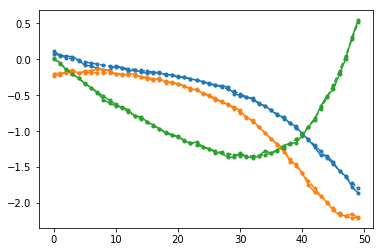

In [118]:
plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'.--');

Slightly worse than the previous version, but not bad for something that's more than twice as fast!

In [87]:
# let's give the model something with a more innocuous name to avoid overwriting it
pred_1 = keras.models.clone_model(predictor)
pred_1.set_weights(predictor.get_weights())